### Modify the file path according to your environment

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CV_HW3/assignment3/'
FOLDERNAME = "ComputerVision/HW3"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets
# !bash get_datasets.sh

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3


# Image Captioning with Transformers
You have now implemented a vanilla RNN and for the task of image captioning. In this notebook you will implement key pieces of a transformer decoder to accomplish the same task.

**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike the RNN notebook.

In [2]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./CV')

from CV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CV.transformer_layers import *
from CV.transformer_layers_drophead import *
from CV.captioning_solver_transformer import CaptioningSolverTransformer
from CV.captioning_solver_transformer_drophead import CaptioningSolverTransformer_drophead
from CV.classifiers.transformer import CaptioningTransformer
from CV.classifiers.transformer_drophead import CaptioningTransformer_drophead
from CV.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from CV.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
As in the previous notebooks, we will use the COCO dataset for captioning.

In [5]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=False)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (376490, 17) int32
train_image_idxs <class 'numpy.ndarray'> (376490,) int32
val_captions <class 'numpy.ndarray'> (184296, 17) int32
val_image_idxs <class 'numpy.ndarray'> (184296,) int32
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
idx_to_word <class 'list'> 50261
word_to_idx <class 'dict'> 50261
train_urls <class 'numpy.ndarray'> (82783,) <U71
val_urls <class 'numpy.ndarray'> (40504,) <U67
nice_feature <class 'numpy.ndarray'> (1000, 4096) float32


# Transformer
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation} \label{qkv_eqn}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation} \label{qkvdropout_eqn}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `CV/transformer_layers.py`. The code below will check your implementation. The relative error should be less than `e-3`.

In [36]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[
[-0.2494,  0.1396,  0.4323, -0.2411, -0.1547,  0.2329, -0.1936,
          -0.1444],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.0625,  0.1503,  0.7572, -0.3974, -0.1681,  0.2168, -0.2478,
          -0.3038]]])

expected_masked_self_attn_output = np.asarray([[
[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3248, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]])

expected_attn_output = np.asarray([[
[-0.1980,  0.4083,  0.1968, -0.3477,  0.0321,  0.4258, -0.8972,
          -0.2744],
         [-0.1603,  0.4155,  0.2295, -0.3485, -0.0341,  0.3929, -0.8248,
          -0.2767],
         [-0.0908,  0.4113,  0.3017, -0.3539, -0.1020,  0.3784, -0.7189,
          -0.2912]]])

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output[0].detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output[0].detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output[0].detach().numpy()))

self_attn_output error:  0.0003775124598178026
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.0003530104862933477


# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `CV/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [37]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.2340,  1.1127,  1.6978, -0.0865, -0.0000,  1.2728],
                                  [ 0.9028, -0.4781,  0.5535,  0.8133,  1.2644,  1.7034]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Transformer for Image Captioning
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model. Open the file `CV/classifiers/transformer.py` and look at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [3]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

# Set all model parameters to fixed values
for p in transformer.parameters():
    p.data = torch.tensor(np.linspace(-1.4, 1.3, num=p.numel()).reshape(*p.shape))

features = torch.tensor(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.tensor((np.arange(N * T) % V).reshape(N, T))

scores = transformer(features, captions)
expected_scores = np.asarray([[[-16.9532,   4.8261,  26.6054],
         [-17.1033,   4.6906,  26.4844],
         [-15.0708,   4.1108,  23.2924]],
        [[-17.1767,   4.5897,  26.3562],
         [-15.6017,   4.8693,  25.3403],
         [-15.1028,   4.6905,  24.4839]],
        [[-17.2172,   4.7701,  26.7574],
         [-16.6755,   4.8500,  26.3754],
         [-17.2172,   4.7701,  26.7574]],
        [[-16.3669,   4.1602,  24.6872],
         [-16.7897,   4.3467,  25.4831],
         [-17.0103,   4.7775,  26.5652]]])
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  5.056720613955726e-06


# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 200) loss: 10.883127
(Iteration 11 / 200) loss: 5.313758
(Iteration 21 / 200) loss: 3.971117
(Iteration 31 / 200) loss: 2.979613
(Iteration 41 / 200) loss: 2.711666
(Iteration 51 / 200) loss: 2.295875
(Iteration 61 / 200) loss: 1.799980
(Iteration 71 / 200) loss: 1.538139
(Iteration 81 / 200) loss: 1.010946
(Iteration 91 / 200) loss: 0.799662
(Iteration 101 / 200) loss: 0.551397
(Iteration 111 / 200) loss: 0.401195
(Iteration 121 / 200) loss: 0.318308
(Iteration 131 / 200) loss: 0.240931
(Iteration 141 / 200) loss: 0.198058
(Iteration 151 / 200) loss: 0.150832
(Iteration 161 / 200) loss: 0.110555
(Iteration 171 / 200) loss: 0.086368
(Iteration 181 / 200) loss: 0.087540
(Iteration 191 / 200) loss: 0.056825


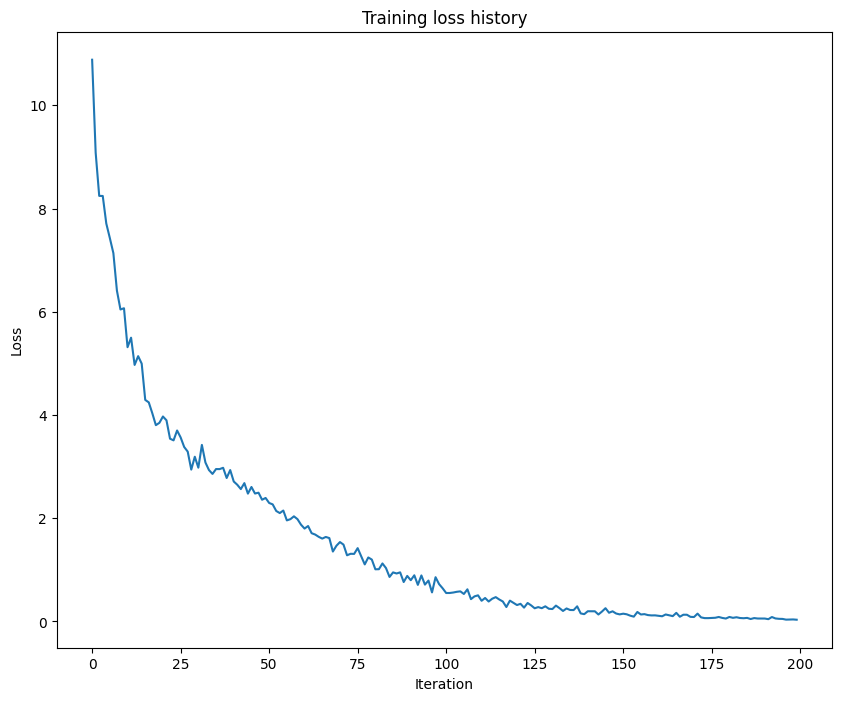

In [ ]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer_drophead = CaptioningTransformer_drophead(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer_drophead(transformer_drophead, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
print(transformer_solver.loss_history[-1])

0.0331362502191541


base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 200) loss: 10.911224
(Iteration 11 / 200) loss: 5.388693
(Iteration 21 / 200) loss: 3.840115
(Iteration 31 / 200) loss: 2.699383
(Iteration 41 / 200) loss: 2.290797
(Iteration 51 / 200) loss: 1.926627
(Iteration 61 / 200) loss: 1.425938
(Iteration 71 / 200) loss: 1.197121
(Iteration 81 / 200) loss: 0.865293
(Iteration 91 / 200) loss: 0.709580
(Iteration 101 / 200) loss: 0.493149
(Iteration 111 / 200) loss: 0.377490
(Iteration 121 / 200) loss: 0.305728
(Iteration 131 / 200) loss: 0.299692
(Iteration 141 / 200) loss: 0.197636
(Iteration 151 / 200) loss: 0.199090
(Iteration 161 / 200) loss: 0.133149
(Iteration 171 / 200) loss: 0.127694
(Iteration 181 / 200) loss: 0.095958
(Iteration 191 / 200) loss: 0.085485


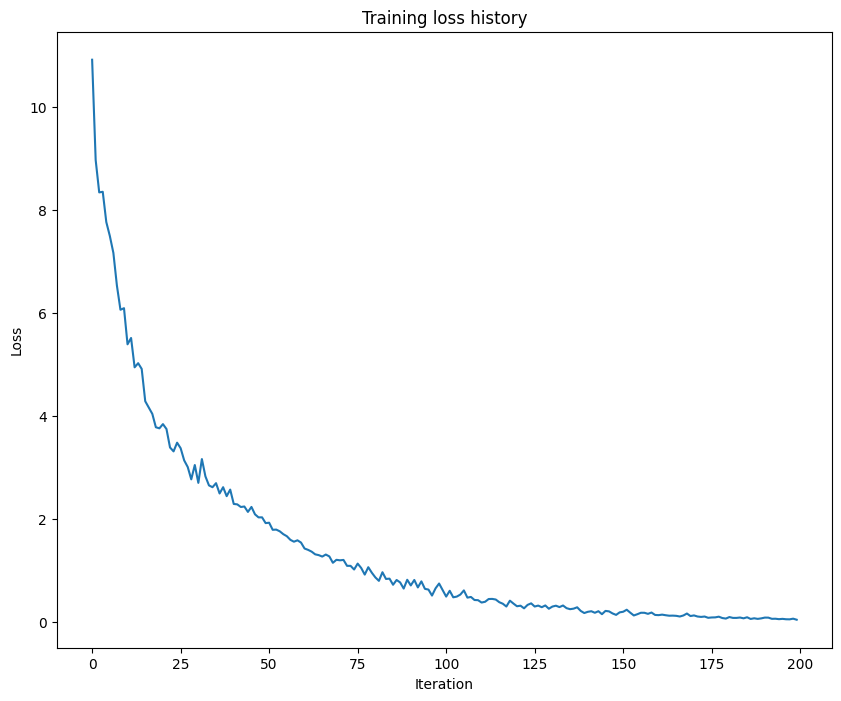

In [31]:
torch.manual_seed(231)
np.random.seed(231)

small_data = load_coco_data(pca_features=False, max_train=50)

transformer_mini = CaptioningTransformer(
          word_to_idx=small_data['word_to_idx'],
          input_dim=small_data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        ).cuda()


transformer_solver = CaptioningSolverTransformer(transformer_mini, small_data, idx_to_word=small_data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.03.

In [32]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.04420129


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the RNN. As before the training results should be much better than the validation set results, given how little data we trained on.

In [ ]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer_mini.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
import sys
!git clone https://github.com/vrama91/cider
sys.path.append('./cider')

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/

import copy
import pickle
from collections import defaultdict
import numpy as np
import math
import os

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self, df_mode="corpus"):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for
                # computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    val[n] += vec_hyp[n][ngram] * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
            return val

        # compute log reference length
        if df_mode == "corpus":
            self.ref_len = np.log(float(len(self.crefs)))
        elif df_mode == "coco-val-df":
            # if coco option selected, use length of coco-val set
            self.ref_len = np.log(float(40504))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, df_mode, option=None, verbose=0):
        # compute idf
        if df_mode == "corpus":
            self.compute_doc_freq()
            # assert to check document frequency
            assert(len(self.ctest) >= max(self.document_frequency.values()))
            # import json for now and write the corresponding files
        else:
            self.document_frequency = pickle.load(open(os.path.join('data', df_mode + '.p'),'r'))
        # compute cider score
        score = self.compute_cider(df_mode)
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

import os
import pdb # python debugger
import sys
import subprocess
import re
import tempfile
import itertools

# path to the stanford corenlp jar
STANFORD_CORENLP_3_4_1_JAR = 'stanford-corenlp-3.4.1.jar'

# punctuations to be removed from the sentences
PUNCTUATIONS = ["''", "'", "``", "`", "-LRB-", "-RRB-", "-LCB-", "-RCB-", \
        ".", "?", "!", ",", ":", "-", "--", "...", ";"]

file_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/"

class PTBTokenizer:
    """Python wrapper of Stanford PTBTokenizer"""
    def __init__(self, _source='gts'):
        self.source = _source

    def tokenize(self, captions_for_image):
        cmd = ['java', '-cp', STANFORD_CORENLP_3_4_1_JAR, \
                'edu.stanford.nlp.process.PTBTokenizer', \
                '-preserveLines', '-lowerCase']

        # ======================================================
        # prepare data for PTB Tokenizer
        # ======================================================

        if self.source == 'gts':
            image_id = [k for k, v in captions_for_image.items() for _ in range(len(v))]
            sentences = '\n'.join([c['caption'].replace('\n', ' ') for k, v in captions_for_image.items() for c in v])
            final_tokenized_captions_for_image = {}

        elif self.source == 'res':
            index = [i for i, v in enumerate(captions_for_image)]
            image_id = [v["image_id"] for v in captions_for_image]
            sentences = '\n'.join(v["caption"].replace('\n', ' ') for v in captions_for_image )
            final_tokenized_captions_for_index = []

        # ======================================================
        # save sentences to temporary file
        # ======================================================
        path_to_jar_dirname=os.path.dirname(file_path)
        tmp_file = tempfile.NamedTemporaryFile(delete=False, dir=path_to_jar_dirname)
        tmp_file.write(sentences.encode("utf-8"))
        tmp_file.close()

        # ======================================================
        # tokenize sentence
        # ======================================================
        cmd.append(os.path.basename(tmp_file.name))
        p_tokenizer = subprocess.Popen(cmd, cwd=path_to_jar_dirname, \
                stdout=subprocess.PIPE)
        token_lines = p_tokenizer.communicate(input=sentences.rstrip())[0]
        lines = token_lines.decode("utf-8").split('\n')
        # remove temp file
        os.remove(tmp_file.name)

        # ======================================================
        # create dictionary for tokenized captions
        # ======================================================
        if self.source == 'gts':
            for k, line in zip(image_id, lines):
                if not k in final_tokenized_captions_for_image:
                    final_tokenized_captions_for_image[k] = []
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_image[k].append(tokenized_caption)

            return final_tokenized_captions_for_image

        elif self.source == 'res':
            for k, img, line in zip(index, image_id, lines):
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_index.append({'image_id': img, 'caption': [tokenized_caption]})

            return final_tokenized_captions_for_index

# from cider.cider_scorer import CiderScorer
# from tokenizer.ptbtokenizer import PTBTokenizer

class Cider:
    def __init__(self, n=4, df="corpus"):
        self._n = n
        self._df = df

    def compute_score(self, gts, res):

        cider_scorer = CiderScorer(n=self._n)

        for res_id in res:

            hypo = res_id['caption']
            ref = gts[res_id['image_id']]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)
            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score(self._df)

        return score, scores

    def method(self):
        return "CIDEr"

class CIDErEvalCap:
    def __init__(self, gts, res, df):
        tokenizer = PTBTokenizer('gts')
        _gts = tokenizer.tokenize(gts)
        tokenizer = PTBTokenizer('res')
        _res = tokenizer.tokenize(res)
        self.gts = _gts
        self.res = _res
        self.df = df

    def evaluate(self):
        # =================================================
        # Set up scorers
        # =================================================

        scorers = [
            (Cider(df=self.df), "CIDEr")
        ]

        metric_scores = {}
        metric_score = {}
        for scorer, method in scorers:
            score, scores = scorer.compute_score(self.gts, self.res)
            metric_score[method] = score
            metric_scores[method] = list(scores)
        return metric_score, metric_scores

fatal: destination path 'cider' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer


In [33]:
import itertools

train_feat = data["train_features"][data["train_image_idxs"]]
gts_cap_train = decode_captions(data["train_captions"], data['idx_to_word'])
res_cap_list = []
minibatch = 100
for i in range(0, len(train_feat), minibatch):
  res_cap_train_curr = decode_captions(transformer_mini.sample(train_feat[i:i+minibatch], max_length=30), data['idx_to_word'])
  res_cap_list.append(res_cap_train_curr)
res_cap_train = list(itertools.chain(*res_cap_list))

gts_train = defaultdict(list)
res_train = []
for i in range(len(data['train_captions'])):
  gts_train[str(data['train_image_idxs'][i])].append({"caption" : gts_cap_train[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['train_image_idxs'][i])
  re_curr["caption"] = res_cap_train[i]
  res_train.append(re_curr)

df_mode = "corpus"
scorer_train = CIDErEvalCap(gts_train, res_train, df_mode)
score_train, scores_train = scorer_train.evaluate()
print(f"train CIDEr : {100 * score_train['CIDEr']}")

val_feat = data["val_features"][data["val_image_idxs"]]
gts_cap_val = decode_captions(data["val_captions"], data['idx_to_word'])

res_cap_list = []
minibatch = 100
for i in range(0, len(val_feat), minibatch):
  res_cap_val_curr = decode_captions(transformer_mini.sample(val_feat[i:i+minibatch], max_length=30), data['idx_to_word'])
  res_cap_list.append(res_cap_val_curr)
res_cap_val = list(itertools.chain(*res_cap_list))

gts_val = defaultdict(list)
res_val = []
for i in range(len(data['val_captions'])):
  gts_val[str(data['val_image_idxs'][i])].append({"caption" : gts_cap_val[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['val_image_idxs'][i])
  re_curr["caption"] = res_cap_val[i]
  res_val.append(re_curr)

df_mode = "corpus"
scorer_val = CIDErEvalCap(gts_val, res_val, df_mode)
score_val, scores_val = scorer_val.evaluate()
print(f"val CIDEr : {100 * score_val['CIDEr']}")

train CIDEr : 12.889211273720974
val CIDEr : 12.603345151724882


In [ ]:
import itertools

train_feat = data["train_features"][data["train_image_idxs"]]
gts_cap_train = decode_captions(data["train_captions"], data['idx_to_word'])

res_cap_list = []
minibatch = 100
for i in range(0, len(train_feat), minibatch):
  res_cap_train_curr = decode_captions(transformer.sample(train_feat[i:i+minibatch], max_length=30), data['idx_to_word'])
  res_cap_list.append(res_cap_train_curr)
res_cap_train = list(itertools.chain(*res_cap_list))

gts_train = defaultdict(list)
res_train = []
for i in range(len(data['train_captions'])):
  gts_train[str(data['train_image_idxs'][i])].append({"caption" : gts_cap_train[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['train_image_idxs'][i])
  re_curr["caption"] = res_cap_train[i]
  res_train.append(re_curr)

df_mode = "corpus"
scorer_train = CIDErEvalCap(gts_train, res_train, df_mode)
score_train, scores_train = scorer_train.evaluate()
print(f"train CIDEr : {100 * score_train['CIDEr']}")

train CIDEr : 83.67893206069307


In [ ]:
val_feat = data["val_features"][data["val_image_idxs"]]
gts_cap_val = decode_captions(data["val_captions"], data['idx_to_word'])

res_cap_list = []
minibatch = 100
for i in range(0, len(val_feat), minibatch):
  res_cap_val_curr = decode_captions(transformer.sample(val_feat[i:i+minibatch], max_length=30), data['idx_to_word'])
  res_cap_list.append(res_cap_val_curr)
res_cap_val = list(itertools.chain(*res_cap_list))

gts_val = defaultdict(list)
res_val = []
for i in range(len(data['val_captions'])):
  gts_val[str(data['val_image_idxs'][i])].append({"caption" : gts_cap_val[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['val_image_idxs'][i])
  re_curr["caption"] = res_cap_val[i]
  res_val.append(re_curr)

df_mode = "corpus"
scorer_val = CIDErEvalCap(gts_val, res_val, df_mode)
score_val, scores_val = scorer_val.evaluate()
print(f"val CIDEr : {100 * score_val['CIDEr']}")

val CIDEr : 74.40019292656902


base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
cuda:0
(Iteration 1 / 301180) loss: 10.914958
(Iteration 1001 / 301180) loss: 2.811321
(Iteration 2001 / 301180) loss: 2.853085
(Iteration 3001 / 301180) loss: 2.736325
(Iteration 4001 / 301180) loss: 2.334365
(Iteration 5001 / 301180) loss: 2.541313
(Iteration 6001 / 301180) loss: 1.945152
(Iteration 7001 / 301180) loss: 2.816092
(Iteration 8001 / 301180) loss: 2.377053
(Iteration 9001 / 301180) loss: 2.161914
(Iteration 10001 / 301180) loss: 2.116336
(Iteration 11001 / 301180) loss: 2.232345
(Iteration 12001 / 301180) loss: 1.989857
(Iteration 13001 / 301180) loss: 2.811894
(Iteration 14001 / 301180) loss: 2.462820
(Iteration 15001 / 301180) loss: 2.310128
(Iteration 16001 / 301180) loss: 2.426206
(Iteration 17001 / 301180) loss: 2.392012
(Iteration 18001 / 301180) loss: 2.314170
(Iteration 19001 / 301180) loss: 2.266291
(Iteration 20001 / 301180) loss: 2.255660
(Iteration 21001 / 301180) 

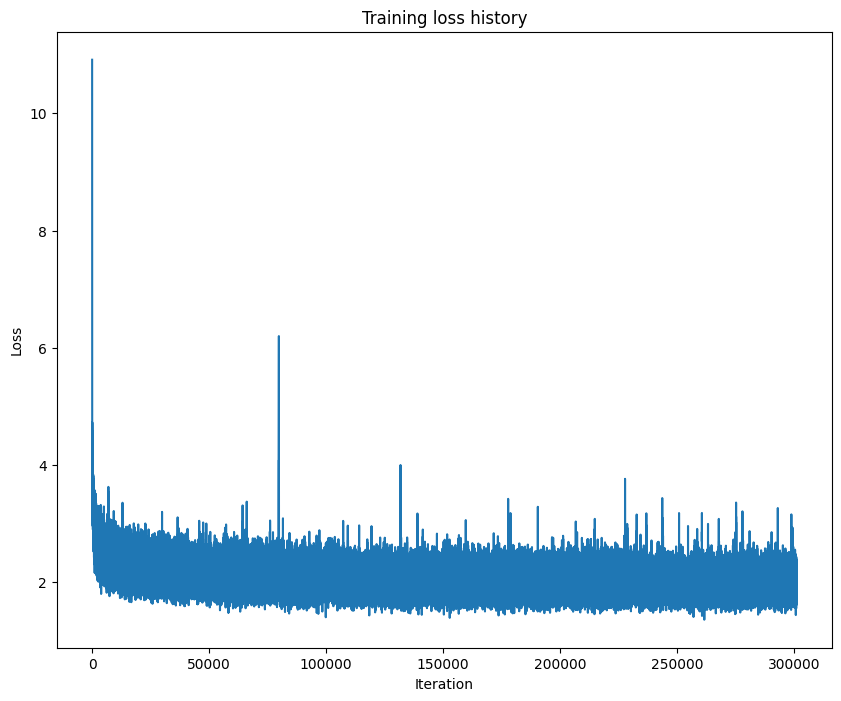

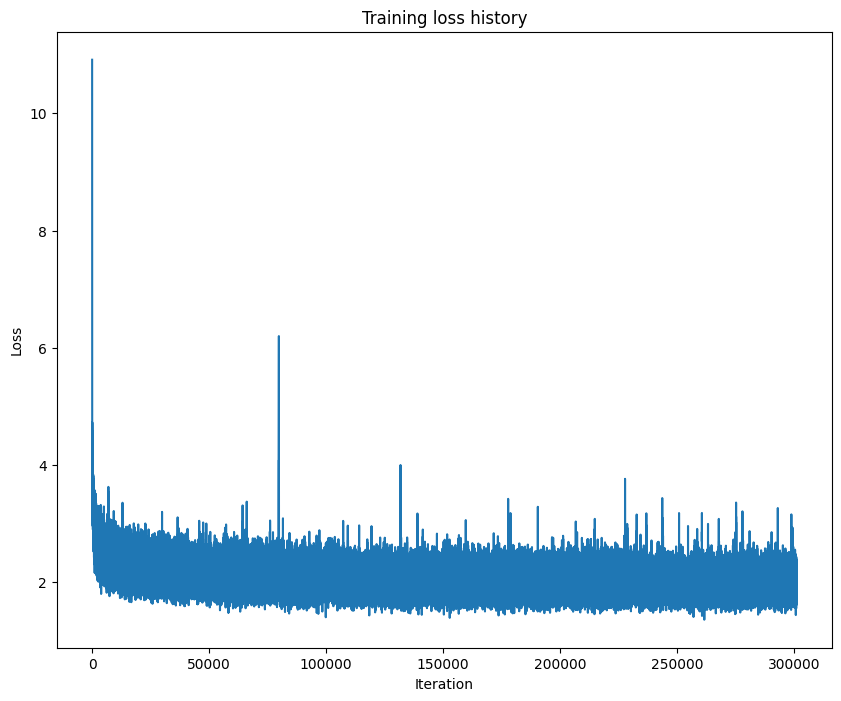

In [ ]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(pca_features=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        ).to(device)

transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=20,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=1000,
         )

transformer_solver.train()

torch.save(transformer.state_dict(), "transformer_state_dict.pt")
# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
data = load_coco_data(pca_features=False)
transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        ).to(device)

transformer.load_state_dict(torch.load("transformer_state_dict.pt"))

cuda:0
base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning


<All keys matched successfully>

In [ ]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=3)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import json
import os
from tqdm import tqdm

def generate_caption(feature):
    sample_captions = transformer.sample(feature, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])[0]
    return sample_captions

student_id = "2022019734"
pred = []
nice_feat = data['nice_feature']
nice_feat = np.expand_dims(nice_feat, axis=1)

for i in tqdm(range(len(nice_feat))):
    caption = generate_caption(nice_feat[i])
    image_id = i + 1
    pred.append({'image_id' : image_id, 'caption' : caption})

result = {"student_id" : student_id, "prediction" : pred}
json.dump(result, open('pred.json', 'w'))

100%|██████████| 1000/1000 [01:33<00:00, 10.66it/s]


base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 301180) loss: 10.907843
(Iteration 1001 / 301180) loss: 2.551973
(Iteration 2001 / 301180) loss: 2.623818
(Iteration 3001 / 301180) loss: 2.595053
(Iteration 4001 / 301180) loss: 2.211899
(Iteration 5001 / 301180) loss: 2.508927
(Iteration 6001 / 301180) loss: 1.881680
(Iteration 7001 / 301180) loss: 2.210046
(Iteration 8001 / 301180) loss: 2.394096
(Iteration 9001 / 301180) loss: 2.231287
(Iteration 10001 / 301180) loss: 2.009134
(Iteration 11001 / 301180) loss: 2.338684
(Iteration 12001 / 301180) loss: 2.092984
(Iteration 13001 / 301180) loss: 2.729254
(Iteration 14001 / 301180) loss: 2.468418
(Iteration 15001 / 301180) loss: 2.233790
(Iteration 16001 / 301180) loss: 2.808983
(Iteration 17001 / 301180) loss: 2.466442
(Iteration 18001 / 301180) loss: 2.548387
(Iteration 19001 / 301180) loss: 2.373083
(Iteration 20001 / 301180) loss: 2.890884
(Iteration 21001 / 301180) loss: 2

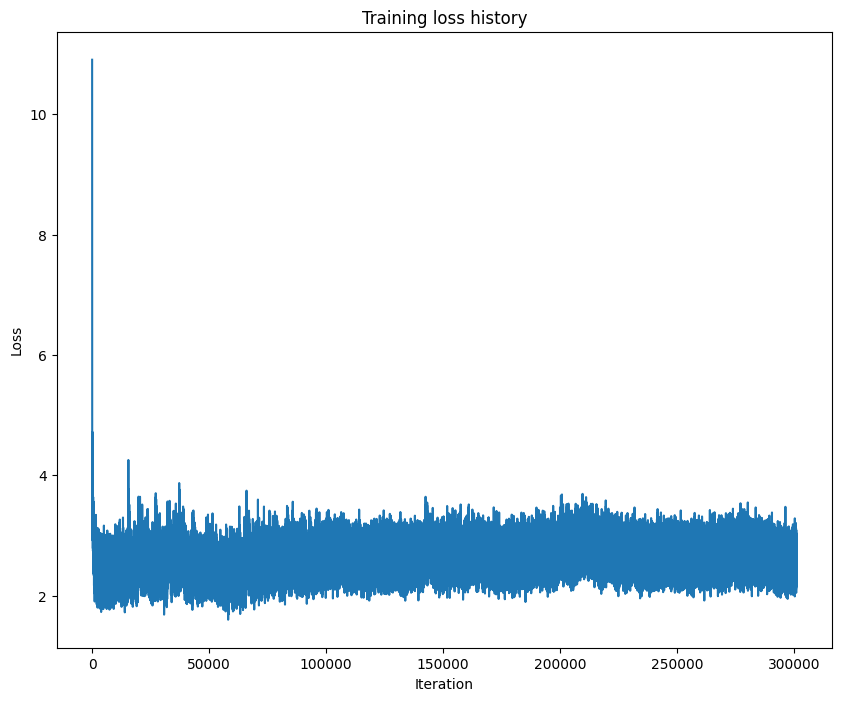

In [4]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(pca_features=False)


transformer_drophead = CaptioningTransformer_drophead(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=16,
          num_layers=2,
          max_length=30
        ).cuda()

transformer_solver_drophead = CaptioningSolverTransformer_drophead(transformer_drophead, data, idx_to_word=data['idx_to_word'],
           num_epochs=20,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=1000,
         )

transformer_solver_drophead.train()

torch.save(transformer_drophead.state_dict(), "transformer_drophead_state_dict2.pt")
# Plot the training losses.
plt.plot(transformer_solver_drophead.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 301180) loss: 10.907807
(Iteration 1001 / 301180) loss: 2.845223
(Iteration 2001 / 301180) loss: 2.720807
(Iteration 3001 / 301180) loss: 2.608050
(Iteration 4001 / 301180) loss: 2.245676
(Iteration 5001 / 301180) loss: 2.383242
(Iteration 6001 / 301180) loss: 2.027766
(Iteration 7001 / 301180) loss: 2.310832
(Iteration 8001 / 301180) loss: 2.465394
(Iteration 9001 / 301180) loss: 4.621647
(Iteration 10001 / 301180) loss: 3.778208
(Iteration 11001 / 301180) loss: 3.134309
(Iteration 12001 / 301180) loss: 3.053614
(Iteration 13001 / 301180) loss: 4.418549
(Iteration 14001 / 301180) loss: 3.879498
(Iteration 15001 / 301180) loss: 3.435111
(Iteration 16001 / 301180) loss: 3.589520
(Iteration 17001 / 301180) loss: 3.424704
(Iteration 18001 / 301180) loss: 3.420110
(Iteration 19001 / 301180) loss: 3.402281
(Iteration 20001 / 301180) loss: 3.429692
(Iteration 21001 / 301180) loss: 3

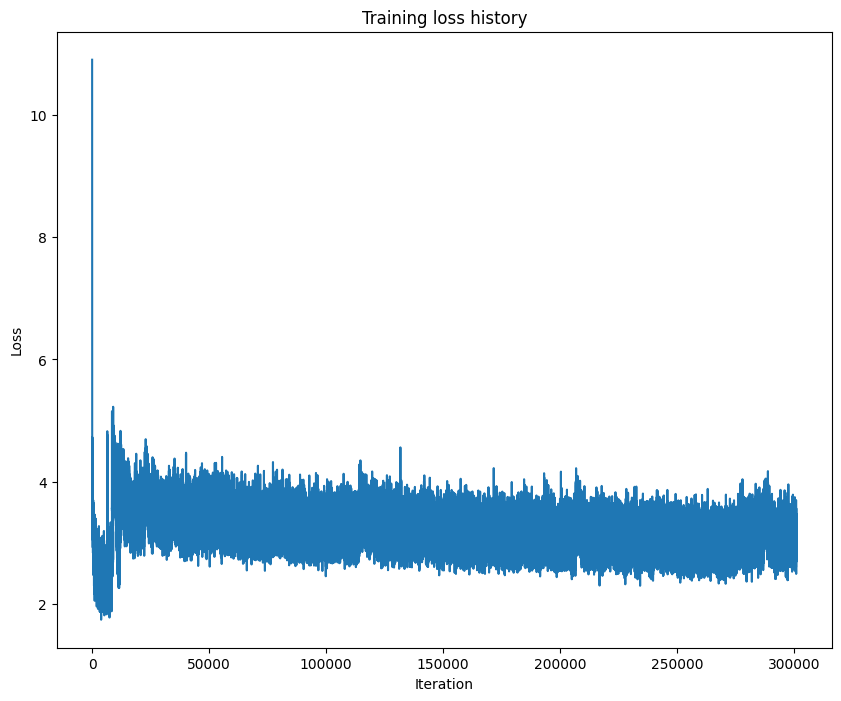

In [ ]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(pca_features=False)


transformer_drophead = CaptioningTransformer_drophead(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        ).cuda()

transformer_solver_drophead = CaptioningSolverTransformer_drophead(transformer_drophead, data, idx_to_word=data['idx_to_word'],
           num_epochs=20,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=1000,
         )

transformer_solver_drophead.train()

torch.save(transformer_drophead.state_dict(), "transformer_drophead_state_dict.pt")
# Plot the training losses.
plt.plot(transformer_solver_drophead.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

minibatch = sample_coco_minibatch(data, split="train", batch_size=1)
gt_captions, features, urls = minibatch
gt_captions = decode_captions(gt_captions, data['idx_to_word'])

sample_captions, attns = transformer_drophead.sample(features, max_length=30)

sample_captions = decode_captions(sample_captions, data['idx_to_word'])
img = None
for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    img = image_from_url(url)
    # Skip missing URLs.
    if img is None: continue
    plt.imshow(img)
    plt.title('%s\nGT:%s' % (sample_caption, gt_caption))
    plt.axis('off')
    plt.show()


word_len = len(sample_captions[0].split())
if img is not None:
  for i in range(word_len):
    curr_attn = attns[0, i]
    curr_attn = curr_attn.unsqueeze(-1).expand(16, 256).reshape(64, 64)
    img_plt = plt.imshow(img)
    plt.imshow(curr_attn, cmap='gray', alpha=0.6, extent=img_plt.get_extent())
    plt.title(sample_captions[0].split()[i])
    plt.show()

In [6]:
import json
import os
from tqdm import tqdm

def generate_caption(feature):
    sample_captions, _ = transformer_drophead.sample(feature, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])[0]
    return sample_captions

student_id = "2022019734"
pred = []
nice_feat = data['nice_feature']
nice_feat = np.expand_dims(nice_feat, axis=1)

for i in tqdm(range(len(nice_feat))):
    caption = generate_caption(nice_feat[i])
    image_id = i + 1
    pred.append({'image_id' : image_id, 'caption' : caption})

result = {"student_id" : student_id, "prediction" : pred}
json.dump(result, open('pred_new.json', 'w'))

100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]


In [14]:
import matplotlib.pyplot as plt

minibatch = sample_coco_minibatch(data, split="train", batch_size=1)
gt_captions, features, urls = minibatch
gt_captions = decode_captions(gt_captions, data['idx_to_word'])

sample_captions, attns = transformer_drophead.sample(features, max_length=30)

sample_captions = decode_captions(sample_captions, data['idx_to_word'])
img = None
for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    img = image_from_url(url)
    # Skip missing URLs.
    if img is None: continue
    plt.imshow(img)
    plt.title('%s\nGT:%s' % (sample_caption, gt_caption))
    plt.axis('off')
    plt.show()


word_len = len(sample_captions[0].split())
if img is not None:
  for i in range(word_len):
    curr_attn = attns[0, i]
    curr_attn = curr_attn.unsqueeze(-1).expand(16, 256).reshape(64, 64)
    img_plt = plt.imshow(img)
    plt.imshow(curr_attn, cmap='gray', alpha=0.6, extent=img_plt.get_extent())
    plt.title(sample_captions[0].split()[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.